# Data Science Challenge

In [ ]:
# To install packages that aren't installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure the notebook has all the dependencies and works everywhere

# import sys
# !{sys.executable} -m pip install -U tensorflow shap

In [30]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from warnings import filterwarnings
pd.set_option('display.float_format', lambda num:'%1.3f'%num)
pd.set_option('display.max_columns', 99)
filterwarnings('ignore')

# Personal Libaries
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, confusion_matrix, make_scorer, accuracy_score, roc_auc_score

# Data Description

Feature | Description
:---|:---
UniqueId |The unique id of a customer.
SocialMedia |The number of different social media webpages visited during the session.
SocialMediaTime |The seconds spent visiting social media web pages.
News|The number of different news( eg. CNN) webpages visited by the prospective customer during the session.
NewsTime|The seconds spent visiting web pages providing news service. 
Blogs|The number Blog web pages visited during the session.
BlogsTime| The seconds spent visiting Blogs web pages.
BounceRate| The percentage of visitors  leaving the page without triggering any other requests during the session.
ExitRate| The value of all pageviews to the page, the percentage that was the last in the session. 
PageValue|The average value for a web page that a user visited before completing an e-commerce transaction
TrafficKind| Web Administration terminology. Categorical feature describing the kind of traffic the website received. 
OS|Categorical feature describing the operating system of the platform connected to the session.
Browser|Categorical feature describing the browser that connected to the session.
Month|It can be handled as discrete or categorical. The month of the connection.
Region|Categorical geographical feature describing the USA region from where the session is initiated.
VisitorKind|This categorical variable describes the kind of visitor.
DayImportance|The closeness of the visit time to a special day (e.g. Mother’s Day, Valentine's Day) 
IsWeekend|Whether it is a weekend or not.
IsSale|Whether this is a transaction or not. This is the Response Variable.

# Data Wrangling & Visualization 




In [4]:
train = pd.read_csv("train.csv", index_col=0)

In [5]:
train.head()

,SocialMedia,SocialMediaTime,News,NewsTime,Blogs,BlogsTime,BounceRate,ExitRate,PageValue,TrafficKind,OS,Browser,Month,Region,VisitorKind,DayImportance,IsWeekend,IsSale
UniqueId,,,,,,,,,,,,,,,,,,
000x41,3.000,87.833,0.000,0.000,27.000,798.333,0.000,0.013,22.916,search,windows,Google-Chrome,Feb,East North Central,Returning,0.800,0.000,True
000x4c,10.000,1005.667,0.000,0.000,36.000,2111.342,0.004,0.014,11.439,direct,windows,Other,Feb,New England,Returning,0.000,0.000,True
000x65,4.000,61.000,0.000,0.000,19.000,607.000,0.000,0.027,17.536,referral,android,Safari,Feb,West South Central,Returning,1.000,1.000,True
000xc6,0.000,0.000,0.000,0.000,17.000,840.233,0.000,0.002,109.176,direct,windows,Google-Chrome,Mar,Pacific,New,0.000,0.000,True
000xc7,3.000,94.000,2.000,125.000,55.000,1970.845,0.000,0.002,96.255,direct,windows,Firefox,Mar,New England,New,0.000,1.000,True


In [6]:
#Explore columns
train.columns

Index(['SocialMedia', 'SocialMediaTime', 'News', 'NewsTime', 'Blogs',
       'BlogsTime', 'BounceRate', 'ExitRate', 'PageValue', 'TrafficKind', 'OS',
       'Browser', 'Month', 'Region', 'VisitorKind', 'DayImportance',
       'IsWeekend', 'IsSale'],
      dtype='object')

In [7]:
#Description
train.describe()

,SocialMedia,SocialMediaTime,News,NewsTime,Blogs,BlogsTime,BounceRate,ExitRate,PageValue,DayImportance,IsWeekend
count,2900.000,2889.000,2892.000,2898.000,2893.000,2901.000,2891.000,2892.000,2891.000,2893.000,2896.000
mean,2.694,94.281,0.607,41.423,37.617,69062.541,0.016,0.034,14.110,0.045,0.261
std,3.566,184.294,1.326,144.907,50.334,2628346.866,0.039,0.041,27.794,0.173,0.439
min,-20.000,0.000,0.000,-1001.000,0.000,-2000056.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,10.000,284.700,0.000,0.012,0.000,0.000,0.000
50%,1.000,27.000,0.000,0.000,22.000,794.993,0.001,0.021,0.000,0.000,0.000
75%,4.000,115.000,1.000,0.000,44.000,1758.250,0.012,0.038,17.829,0.000,1.000
max,27.000,2720.500,12.000,1767.667,584.000,100099000.000,0.200,0.200,360.953,1.000,1.000


## Zack's Exploratory Data Analysis
My overall objective when I first look to develop a model is to form a **baseline**. To do so, my initial EDA and even *Feature Engineering* is minimal. The reason behind this is I want to really observe how good of a model I can develop without extensive engineering or manipulating of the data.

My EDA process will go as follows:

* **Split Data by Numerical & Categorical Features:** This really makes analysis, feature engineering, and modeling quite easy for to keep the features organized.
* **Observe the Target's distribution to see if I will need to handle data imbalance:** Data Imbalance is a very common problem in industry so its imperative check. Solving this can be quite hard as I'll have to choose between Oversampling & Undersampling to rebalance the data. This could possibly skew your model's results.
* **Check for Missing Values:** Because data isn't always clean and data quality can sometimes be poor, understand how much of the data is missing is key to the cleaning phase.
* **Check for High Cardinality:** If features have high cardinality, it could damage the model. It's important to either remove or bin the features.
* **Check Numerical Distributions:** The distributions can help identify a few things. One is how to handle its missing values if needed. Another is to see if that numerical value should actually be categorical. One last reason to look at numerical distributions is to see whether the feature has very low variation in its values which let's us know that the feature doesn't carry much information for our model to learn from.
* **Check Correlation Matrix:** Features that are highly correlated doesn't need to be present in our model.

In [8]:
ignore_cols = []

def split_num_cat_features(df, target=None):
    num_features = [col for col in df if df[col].dtype==float or df[col].dtype==int and col!=target]
    cat_features = [col for col in df.columns if col not in num_features and col!=target]
    return target, num_features, cat_features

target, num_features, cat_features = split_num_cat_features(train, 'IsSale')

print(f'Target = {target}')
print(f'Numerical Features = {num_features}')
print(f'Categorical Features = {cat_features}')

Target = IsSale
Numerical Features = ['SocialMedia', 'SocialMediaTime', 'News', 'NewsTime', 'Blogs', 'BlogsTime', 'BounceRate', 'ExitRate', 'PageValue', 'DayImportance', 'IsWeekend']
Categorical Features = ['TrafficKind', 'OS', 'Browser', 'Month', 'Region', 'VisitorKind']


In [9]:
train[target].value_counts(normalize=True)

False   0.515
True    0.485
Name: IsSale, dtype: float64

#### This is great that data is well balanced. This gives me a little confidence in the performance of my model.

In [10]:
def check_missing_values(df, missing_thresh=60.0, zero_thresh=40.0):
    missing_zeros_df = pd.DataFrame({
        'percent_missing': round(df.isna().sum() * 100/len(df),2),
        'percent_zero': round(df.isin([0]).sum() * 100 / len(df),2),
    }).sort_values(['percent_missing', 'percent_zero'], ascending=False)
    
    high_missing_zeros = missing_zeros_df[(missing_zeros_df.percent_missing > missing_thresh) \
                                          | (missing_zeros_df.percent_zero > zero_thresh)].index
    
    return missing_zeros_df, list(high_missing_zeros)

def plot_num_hist(df, c, i, bins=10):
    plt.figure(i)
    sns.distplot(df[c], bins=bins)
    plt.title(f"Distribution of {c.upper()} Feature... ")

def create_cardinality_table(df, cat_features, threshold=0.05):
    cardinality_df = pd.DataFrame(df[cat_features] \
                        .apply(pd.Series.nunique) \
                        .sort_values(ascending=False),
                        columns=['Cardinality'])
    high_card_cols = cardinality_df[cardinality_df.Cardinality > len(df)*threshold].index
    return cardinality_df, list(high_card_cols)

def check_correlation(df):
    corrMatrix = df.corr()
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
    plt.show()

In [12]:
missing_zeros_df, high_missing_zeros_cols = check_missing_values(train)
print(f'Columns with High Missing/Zero Values: {high_missing_zeros_cols}')
pd.DataFrame(missing_zeros_df)

Columns with High Missing/Zero Values: ['SocialMediaTime', 'PageValue', 'BounceRate', 'News', 'DayImportance', 'IsWeekend', 'NewsTime', 'IsSale']


,percent_missing,percent_zero
SocialMediaTime,0.650,40.610
TrafficKind,0.650,0.000
PageValue,0.580,55.160
BounceRate,0.580,48.900
Browser,0.580,0.000
News,0.550,73.420
ExitRate,0.550,1.000
DayImportance,0.520,92.130
Blogs,0.520,0.380
VisitorKind,0.520,0.000


`DayImportance` has 92% zeros. We can assume that not much information is there for our model learn from. Although the others have high percentage of zeros such as `News`, `IsWeekend`, and `NewsTime`, it will be a bigger assumption to establish whether we should remove them or not. So for now, I will keep them!

In [13]:
cardinality_df, high_card_cols = create_cardinality_table(train, cat_features)
print(f'Columns with High Cardinality: {high_card_cols}')
pd.DataFrame(cardinality_df)

Columns with High Cardinality: []


,Cardinality
Month,10
Region,9
Browser,5
OS,5
TrafficKind,4
VisitorKind,3


#### No high cardinality in the data is which good. Starting to look like this dataset carries good information.

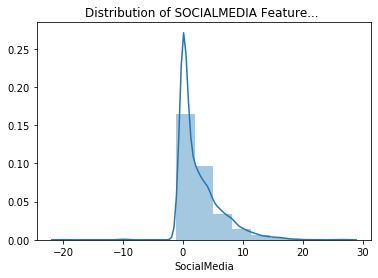

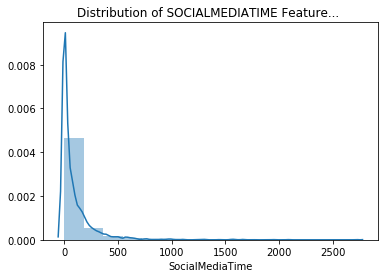

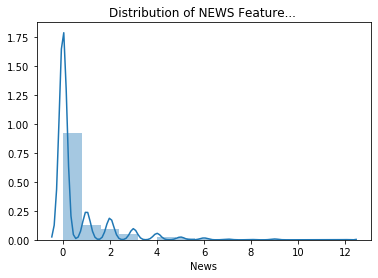

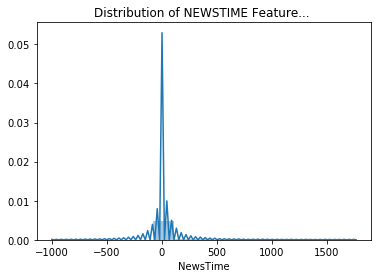

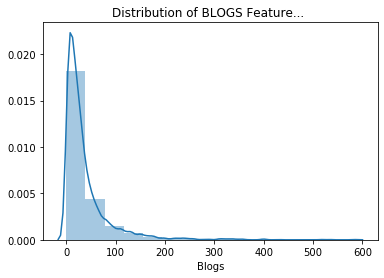

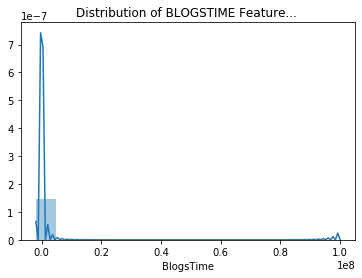

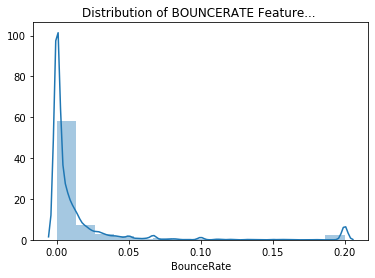

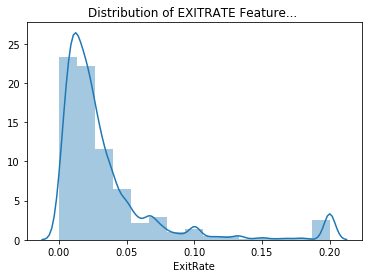

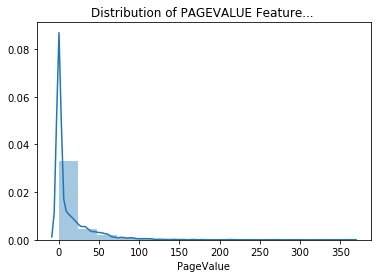

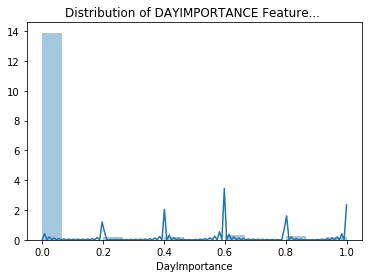

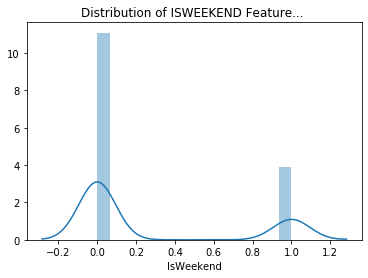

In [15]:
for i, n in enumerate(num_features):
    plot_num_hist(train, n, i, bins=15)

Definitely looks like `IsWeekend` is categorical instead of numerical. I will convert this during the *Feature Engineering* stage.

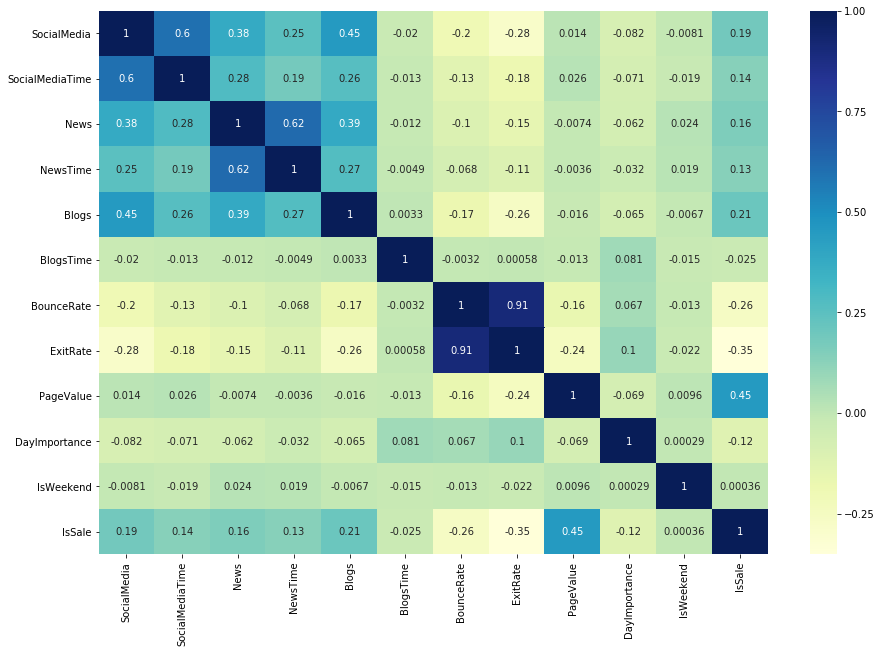

In [16]:
check_correlation(train)

I can pay much more attention to this **correlation heatmap**, but for the baseline, I will only keep this information in mind. However, notice how highly positively correlated some of the features are. (ex. `News` and `NewsTime` have positive correlation of **0.6**) 

## Zack's Feature Engineering

Here I handle the concerns I pointed out above including *encoding the categorical data*.

In [18]:
# Remove Unwanted Columns
for c in ['NewsTime', 'DayImportance']:
    ignore_cols.append(c)

selected_cols = [col for col in cat_features+num_features if col not in ignore_cols]
train_selected = train[selected_cols+[target]]
train_selected.head()

,TrafficKind,OS,Browser,Month,Region,VisitorKind,SocialMedia,SocialMediaTime,News,Blogs,BlogsTime,BounceRate,ExitRate,PageValue,IsWeekend,IsSale
UniqueId,,,,,,,,,,,,,,,,
000x41,search,windows,Google-Chrome,Feb,East North Central,Returning,3.000,87.833,0.000,27.000,798.333,0.000,0.013,22.916,0.000,True
000x4c,direct,windows,Other,Feb,New England,Returning,10.000,1005.667,0.000,36.000,2111.342,0.004,0.014,11.439,0.000,True
000x65,referral,android,Safari,Feb,West South Central,Returning,4.000,61.000,0.000,19.000,607.000,0.000,0.027,17.536,1.000,True
000xc6,direct,windows,Google-Chrome,Mar,Pacific,New,0.000,0.000,0.000,17.000,840.233,0.000,0.002,109.176,0.000,True
000xc7,direct,windows,Firefox,Mar,New England,New,3.000,94.000,2.000,55.000,1970.845,0.000,0.002,96.255,1.000,True


In [21]:
def fill_missing(df, numerical_features, categorical_features, num_impute='median'):
    ismissing = df.isna().values.any()
    if ismissing:
        print(f'Imputing Missing Numerical Values with {num_impute} ...')
        for col in numerical_features:
            if num_impute=='mean':
                df[col] = df[col].fillna(df[col].mean())
            else:
                df[col] = df[col].fillna(df[col].median())
        print('Done!')
        print(f'Imputing Missing Categorical Values with UNK ...')
        for col in categorical_features:
            df[col] = df[col].fillna('UNK')
        print('Done!')
    print(f'No Missing Data!')
    return df

def convert_to_categorical(df, cols):
    for col in cols:
        df[col] = df[col].astype('category', copy=False)
    
    df_encoded = df.copy()
    for col in cols:
        df_encoded[col] = df_encoded[col].cat.codes
    return df, df_encoded

In [23]:
processed_df = train_selected.copy()
_, numerical_features, categorical_features = split_num_cat_features(processed_df)
categorical_features += ['IsWeekend']
categorical_features = [c for c in categorical_features if c!=target]

processed_df = fill_missing(processed_df, numerical_features, categorical_features)
processed_df, encoded_df = convert_to_categorical(processed_df, categorical_features)
processed_df.head()

Imputing Missing Numerical Values with median ...
Done!
Imputing Missing Categorical Values with UNK ...
Done!
No Missing Data!


,TrafficKind,OS,Browser,Month,Region,VisitorKind,SocialMedia,SocialMediaTime,News,Blogs,BlogsTime,BounceRate,ExitRate,PageValue,IsWeekend,IsSale
UniqueId,,,,,,,,,,,,,,,,
000x41,search,windows,Google-Chrome,Feb,East North Central,Returning,3.000,87.833,0.000,27.000,798.333,0.000,0.013,22.916,0.000,True
000x4c,direct,windows,Other,Feb,New England,Returning,10.000,1005.667,0.000,36.000,2111.342,0.004,0.014,11.439,0.000,True
000x65,referral,android,Safari,Feb,West South Central,Returning,4.000,61.000,0.000,19.000,607.000,0.000,0.027,17.536,1.000,True
000xc6,direct,windows,Google-Chrome,Mar,Pacific,New,0.000,0.000,0.000,17.000,840.233,0.000,0.002,109.176,0.000,True
000xc7,direct,windows,Firefox,Mar,New England,New,3.000,94.000,2.000,55.000,1970.845,0.000,0.002,96.255,1.000,True


In [24]:
encoded_df.head()

,TrafficKind,OS,Browser,Month,Region,VisitorKind,SocialMedia,SocialMediaTime,News,Blogs,BlogsTime,BounceRate,ExitRate,PageValue,IsWeekend,IsSale
UniqueId,,,,,,,,,,,,,,,,
000x41,4,5,1,2,0,2,3.000,87.833,0.000,27.000,798.333,0.000,0.013,22.916,0,1
000x4c,2,5,2,2,4,2,10.000,1005.667,0.000,36.000,2111.342,0.004,0.014,11.439,0,1
000x65,3,1,3,2,9,2,4.000,61.000,0.000,19.000,607.000,0.000,0.027,17.536,1,1
000xc6,2,5,1,5,5,0,0.000,0.000,0.000,17.000,840.233,0.000,0.002,109.176,0,1
000xc7,2,5,0,5,4,0,3.000,94.000,2.000,55.000,1970.845,0.000,0.002,96.255,1,1


In [25]:
processed_df.shape

(2908, 16)

# Visualization, Modeling, Machine Learning

Build a model that can predict the probability that a visit can be converted to a transaction and identify how different features influence the decision. Please explain the findings for technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of roc_auc_score.**
- **Read the test.csv file and prepare features for testing.**


In [29]:
test = pd.read_csv("test.csv", index_col=0)
print(f'Test Shape: {test.shape}')
test.head()

Test Shape: (1000, 17)


,SocialMedia,SocialMediaTime,News,NewsTime,Blogs,BlogsTime,BounceRate,ExitRate,PageValue,TrafficKind,OS,Browser,Month,Region,VisitorKind,DayImportance,IsWeekend
UniqueId,,,,,,,,,,,,,,,,,
0x1de1,5.000,277.800,0.000,0.000,25.000,884.500,0.000,0.004,7.481,direct,windows,Other,Jul,Mid-Atlantic,New,0.000,1.000
0x21eb,7.000,190.438,0.000,0.000,60.000,1967.780,0.004,0.015,2.627,referral,mac-ios,Google-Chrome,Dec,Mountain,Returning,0.000,1.000
0x2f6a,0.000,0.000,0.000,0.000,5.000,586.000,0.000,0.060,0.000,referral,windows,Firefox,Nov,Pacific,Returning,0.000,1.000
0x25f0,2.000,88.000,10.000,719.000,54.000,1986.553,0.005,0.020,25.827,direct,android,Safari,Dec,Mid-Atlantic,Returning,0.000,0.000
0x2be0,12.000,1276.264,0.000,0.000,118.000,3215.173,0.000,0.005,22.458,search,mac-ios,Google-Chrome,Nov,Mountain,Returning,0.000,0.000


### Zack's Baseline Modeling

Although I know a test set is available, it does not hold the **target** variable which is key for evaluation. For this purpose, I will split the data into a validation set.

In [31]:
features = [col for col in encoded_df.columns if col!=target]
X = encoded_df[features]
y = encoded_df[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3, random_state=42)
print(f'Train Data Shape: {X_train.shape, y_train.shape}')
print(f'Validation Data Shape: {X_valid.shape, y_valid.shape}')

Train Data Shape: ((2035, 15), (2035,))
Validation Data Shape: ((873, 15), (873,))


### Random Forest

As discussed in the phone screen with Parth, **Random Forest has become my baseline and favorite algorithm** over the years for a multitude of reasons. One of those reasons how well it fits any data representation and explains the important features. Here I run some *cross validation and hyperparameter tuning using GridSearch* to ensure I choose a really good Random Forest config.

In [32]:
rf = RandomForestClassifier()

parameters = {"n_estimators": [5, 10, 15], 
              "criterion": ["gini", "entropy"],
              "max_features": ["auto", "sqrt", "log2"], 
              "max_depth": [2, 4, 6], 
              "min_samples_split": [2, 6, 12],
              "min_samples_leaf": [1, 5, 10]
             }

grid_cv = GridSearchCV(rf, parameters, scoring = make_scorer(accuracy_score))
grid_cv = grid_cv.fit(X_train, y_train)

print("Our optimized Random Forest model is:")
grid_cv.best_estimator_

Our optimized Random Forest model is:


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
rf_clf = grid_cv.best_estimator_
rf_clf.fit(X_train, y_train)
pred_rf = rf_clf.predict(X_valid)
pred_rf_probs = rf_clf.predict_proba(X_valid)[:,1]
acc_rf = accuracy_score(y_valid, pred_rf)
auc_rf = roc_auc_score(y_valid, pred_rf)

print(f'Accuracy: {acc_rf}')
print(f'AUC: {auc_rf}')

Accuracy: 0.847651775486827
AUC: 0.8477720044087544


### Baseline Performance
For classification problems, I really like to observe both **Accuracy and Area Under the Curve (AUC)**. These metrics give me a really good sense at how my model is classifying the data. My baseline Random Forest model has done quite well on the validation set in which I'd be super confident in submitting for this test. But I will like to see if I could improve on it later.

In [77]:
test_results = pd.DataFrame({'Actual': y_valid, 'Predict': pred_rf, 'Probability': pred_rf_probs})
test_results.head(10).transpose()

UniqueId,0x247a,0x2346,0x24b2,0x173b,0x2f3a,0x2065,0x1acb,0x21a1,0x2277,0x2eca
Actual,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000
Predict,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
Probability,0.168,0.688,0.733,0.364,0.073,0.808,0.140,0.424,0.199,0.331


### Single Sample Prediction & Explanation

I always like to see how my model predicts in single sample scenarios. This is the closest I will get to real-world scenerios that will possibly be classified by my model.

In [85]:
def get_sample(data, org_data, idx):
    sample = data.iloc[idx]
    print(f'Target Value: {org_data[target].iloc[idx]}')
    return sample

sample = get_sample(X_valid, train, 2)
pd.DataFrame(sample)

Target Value: True


,0x24b2
TrafficKind,2.000
OS,3.000
Browser,1.000
Month,7.000
Region,0.000
VisitorKind,2.000
SocialMedia,17.000
SocialMediaTime,195.486
News,1.000
Blogs,94.000


In [86]:
def explain_single_pred(sample):
    sample_np = pd.Series(sample)
    explainer = shap.TreeExplainer(rf_clf)
    shap_values = explainer.shap_values(sample_np)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], sample_np)

explain_single_pred(sample)

**SHAP** allow me to display how much of an impact each feature has on the outcome. For this sample I predict a value of 0.73 which is closer to 1. This tells me that **my model predicted that this particular visit by a customer will turn into a Sale**. Let's try another one.

In [90]:
sample = get_sample(X_valid, train, 4)
explain_single_pred(sample)

Target Value: True




**The management wants to know what are the most important features for the model.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**

Because there are only 15 features in my model, I can only display those importances. But here we can see that my model shows `PageValue`, `BlogsTime`, `Blogs`, `ExitRate`, and `BounceRate` are the top 5 features that has the biggest impact for predicting whether a visit to the store will end in a Sale or not.

In [78]:
featureImp_list = []
for feat, importance in zip(X_train.columns, rf_clf.feature_importances_):  
    temp = [feat, importance]
    featureImp_list.append(temp)

featureImp_df = pd.DataFrame(featureImp_list, columns = ['Feature', 'Importance'])
featureImp_df.sort_values('Importance', ascending = False)

,Feature,Importance
13,PageValue,0.538
10,BlogsTime,0.104
9,Blogs,0.083
12,ExitRate,0.080
11,BounceRate,0.066
7,SocialMediaTime,0.035
3,Month,0.026
6,SocialMedia,0.024
5,VisitorKind,0.011
0,TrafficKind,0.011


- **Submit the predictions on the test dataset using your optimized model**

    For each record in the test set (`test.csv`), predict the probability of the `IsSale` variable. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:
   - **UniqueId**
   - **IsSale**

In [79]:
test_proc = test[features]
test_proc = fill_missing(test_proc, numerical_features, categorical_features)
_, test_proc = convert_to_categorical(test_proc, categorical_features)

test_pred_probs = rf_clf.predict_proba(test_proc)[:,1]

test_results = pd.DataFrame({'Probability': test_pred_probs})
test_results.head(10).transpose()

Imputing Missing Numerical Values with median ...
Done!
Imputing Missing Categorical Values with UNK ...
Done!
No Missing Data!


,0,1,2,3,4,5,6,7,8,9
Probability,0.822,0.661,0.258,0.744,0.743,0.140,0.174,0.135,0.745,0.397


In [81]:
submission_df = pd.DataFrame(test.index)
submission_df['IsSale'] = test_pred_probs
submission_df.head()

,UniqueId,IsSale
0,0x1de1,0.822
1,0x21eb,0.661
2,0x2f6a,0.258
3,0x25f0,0.744
4,0x2be0,0.743


In [82]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

## Model Improvement using TensorFlow & Keras

I always love to see if I can develop a very simple model using TensorFlow to improve on my Random Forest baseline. For Neural Networks, **Standard Scaling** is imperative.

In [92]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.121,0.853,-0.502,0.706,-1.336,0.441,0.647,5.064,1.074,-0.606,-0.031,-0.393,0.097,-0.495,1.674
1,0.121,0.853,-0.502,1.116,-0.606,-2.234,-0.479,-0.385,-0.463,-0.665,-0.031,-0.393,0.146,0.756,-0.597
2,1.261,0.853,-0.502,-0.933,-1.336,0.441,0.084,-0.167,0.305,-0.149,-0.031,-0.393,-0.590,-0.027,1.674
3,-1.019,-0.351,-0.502,-2.163,-1.336,-2.234,1.491,1.119,-0.463,-0.407,-0.031,-0.393,-0.369,0.730,-0.597
4,1.261,-1.556,1.425,0.706,0.124,0.441,-0.760,-0.541,1.074,-0.646,-0.031,-0.393,0.563,-0.495,-0.597


#### 3-Layer Neural Network

Including the output layer which is *Logistic Regression* in its nature, I built this regularized model that includes **L2 weight decay on all hidden layers as well as Dropout on the output of the first 2 layers**.

In [93]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.AUC(name='auc')]

def build_model(input_shape, metrics=METRICS):
    model = Sequential([Dense(16, input_dim=input_shape, activation='relu', kernel_regularizer=l2(0.001)),
                        Dropout(0.05),
                        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
                        Dropout(0.05),
                        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
                        Dense(1, activation='sigmoid')])

    model.compile(
        optimizer=Adam(lr=1e-3),
        loss='binary_crossentropy',
        metrics=metrics)

    return model

model = build_model(X_train.shape[-1], metrics=METRICS)
model.summary()

def train_model(model, X_train, y_train, validation_data, epochs=10, batch_size=32, callbacks=None):
    return model.fit(
        X_train, y_train,
        validation_data=validation_data,
        epochs=epochs, batch_size=batch_size,
        callbacks=callbacks
    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                256       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
______________________________________________________

In my experience using Deep Learning, **callbacks** are very important to keep a handle on the training process. The 3 I like to use are ModelCheckpoint to save the best model during training, Early Stopping, and Reduce Learning Rate on Plateau.

In [94]:
CALLBACKS = [
             ModelCheckpoint(filepath='models/bestModelCheckpoint',
                             save_best_only=True, monitor='val_loss', mode='min'),
             EarlyStopping(monitor='val_loss', mode='min', patience=10), 
             ReduceLROnPlateau(factor=0.2, patience=5)
]

history = train_model(model, X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), callbacks=CALLBACKS, epochs=100)

Epoch 1/100
64/64 [==============================] - 1s 10ms/step - loss: 0.7435 - accuracy: 0.5485 - auc: 0.5907 - val_loss: 0.6660 - val_accuracy: 0.6586 - val_auc: 0.7423
INFO:tensorflow:Assets written to: models/bestModelCheckpoint/assets
Epoch 2/100
64/64 [==============================] - 0s 4ms/step - loss: 0.6488 - accuracy: 0.6631 - auc: 0.7523 - val_loss: 0.6128 - val_accuracy: 0.7159 - val_auc: 0.8031
INFO:tensorflow:Assets written to: models/bestModelCheckpoint/assets
Epoch 3/100
64/64 [==============================] - 0s 4ms/step - loss: 0.6049 - accuracy: 0.7218 - auc: 0.7974 - val_loss: 0.5770 - val_accuracy: 0.7262 - val_auc: 0.8305
INFO:tensorflow:Assets written to: models/bestModelCheckpoint/assets
Epoch 4/100
64/64 [==============================] - 0s 4ms/step - loss: 0.5520 - accuracy: 0.7515 - auc: 0.8367 - val_loss: 0.5462 - val_accuracy: 0.7526 - val_auc: 0.8501
INFO:tensorflow:Assets written to: models/bestModelCheckpoint/assets
Epoch 5/100
64/64 [============

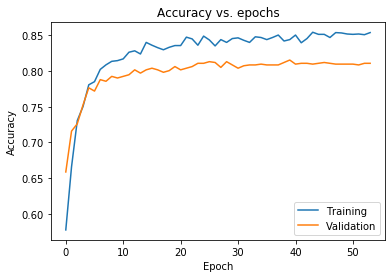

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

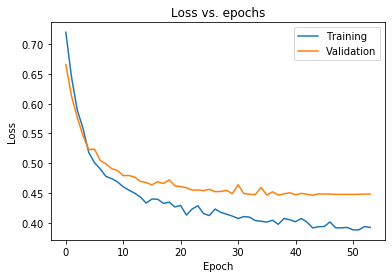

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

My DNN converge really well during training and even **beats the performance of my Random Forest baseline** as it relates to the AUC metric with a score of **0.90**.

In [98]:
loss, acc, auc = model.evaluate(X_valid_scaled, y_valid, verbose=0)
print(f'Loss    : {round(loss, 2)}')
print(f'Accuracy: {round(acc, 2)}')
print(f'AUC     : {round(auc, 2)}')

Loss    : 0.45
Accuracy: 0.81
AUC     : 0.9


Let's predict a few single samples.

In [99]:
def predict_single_sample(model, sample):
    if isinstance(sample, dict):
        sample_scaled = scaler.transform(np.array(list(sample.values())).reshape(1,-1))
        pred = model.predict_classes(np.array(sample_scaled,))[0][0]
    else:
        sample_scaled = scaler.transform(np.array(sample).reshape(1,-1))
        pred = model.predict_classes(sample_scaled)[0][0]
    print(f'Prediction: {pred}') 

def predict_batch_samples(model, samples):
    samples_scaled = scaler.transform(samples)
    return model.predict_proba(samples_scaled).squeeze()

predict_single_sample(model, sample)
# predict_batch_samples(model, X_test)

Prediction: 0


In [102]:
sample = get_sample(X_valid, train, 5)
predict_single_sample(model, sample)

Target Value: True
Prediction: 1


In [104]:
y_preds = predict_batch_samples(model, X_valid)
y_preds.shape == y_valid.shape

True

In [106]:
test_results_nn = pd.DataFrame({'Actual': y_valid, 'Predict': y_preds})
test_results_nn.head(10).transpose()

UniqueId,0x247a,0x2346,0x24b2,0x173b,0x2f3a,0x2065,0x1acb,0x21a1,0x2277,0x2eca
Actual,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000
Predict,0.167,0.155,0.472,0.116,0.029,0.961,0.057,0.230,0.079,0.263


### Optimal Version of Model

One of the best ways I've found was, of course depending on the business requirements, where does my model shine. Here I want to find the balance between the **Precision and the Recall**, then calculate the **Threshold** at that point.

In [108]:
precision, recall, thresholds = precision_recall_curve(test_results_nn['Actual'], test_results_nn['Predict'])

def  calc_f1(precision, recall):
    return 2*(precision*recall)/(precision+recall)

What if I Prioritize Precision?

In [109]:
# Look at the threshold where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
precision_thresh = thresholds[idx]
print(f'Precision is: {precision[idx]}')
print(f'Recall is: {recall[idx]}')
print(f'Threshold is: {precision_thresh}')
print(f'F1 Score is: {calc_f1(precision[idx], recall[idx])}')

Precision is: 0.8
Recall is: 0.0091324200913242
Threshold is: 0.9966121912002563
F1 Score is: 0.01805869074492099


What if I Prioritize Recall?

In [110]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
recall_thresh = thresholds[idx]
print(f'Precision is: {precision[idx]}')
print(f'Recall is: {recall[idx]}')
print(f'Threshold is: {recall_thresh}')
print(f'F1 Score is: {calc_f1(precision[idx], recall[idx])}')

Precision is: 0.8235294117647058
Recall is: 0.7990867579908676
Threshold is: 0.4211532175540924
F1 Score is: 0.8111239860950173


The Recall Optimization gives me the most promise and balance. Now I'd want to calculate the Accuracy at those two thresholds just to make sure.

In [112]:
probs = test_results_nn['Predict']
t1 = (probs > precision_thresh)
t1 = t1.replace(True,1).replace(False,0)
compare_t1 = (t1 == test_results_nn['Actual'])

print('Accuracy based on Precision Threshold: ' + str(len(compare_t1[compare_t1])/len(test_results_nn)))

Accuracy based on Precision Threshold: 0.5005727376861397


In [113]:
probs = test_results_nn['Predict']
t1 = (probs > recall_thresh)
t1 = t1.replace(True,1).replace(False,0)
compare_t1 = (t1 == test_results_nn['Actual'])

print('Accuracy based on Precision Threshold: ' + str(len(compare_t1[compare_t1])/len(test_results_nn)))

Accuracy based on Precision Threshold: 0.8121420389461627


## Conclusion & Improvements
As I'm writing this portion of the test, I have 20mins left. If given more time, I'd do the following:

* Pay more attention to the **Feature Engineering** stage. This will possibly include more transformations and maybe even feature creations.
* Detect and Treat **Outliers**
* **Try more models**. I'd love to try Decision Tree to see if I can try a more simpler model. I *tried Logistic Regression as apart of my Neural Network training, but was horribly underfitting* the data so I added more layers. Maybe a Decision Tree will balance out the model complexity and I can optimize for both Bias and Variance in the model
* Evaluate the **Confusion Matrix** to really get a since of the *False Positives* and maybe optimize for that as well.

Thanks for considering me for this test and position. Hopefully I was able to display and capture my thought process during this challenge.

Zacchaeus Williams
02/19/2021